# Libraries

In [1]:
import requests
import os
import yaml
os.chdir('../')

In [2]:
import datetime

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
params = {'legend.fontsize': 14,
          'figure.figsize': (15, 8),
         'axes.labelsize': 14,
         'axes.titlesize': 14,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14}
plt.rcParams.update(params)
pd.options.display.max_columns = 50
pd.options.display.precision = 2

In [5]:
from cloudant.view import View
from cloudant.client import Cloudant
from cloudant.document import Document

In [6]:
def unfold_keys(df):
    df = df.copy()
    key_column = 'key'
    for i in range(0, len(df.loc[0,key_column])):
        df.insert(i, 'level_{}'.format(i+1), df[key_column].apply(lambda x: x[i]))
    del df[key_column]
    return df

In [7]:
with open("config.yaml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

In [8]:
cfg = cfg['COUCHDB']
client = Cloudant(cfg['user'], cfg['password'], url=cfg['host'])
client.connect()
tweets_db = client[cfg['tweets_db']]
aurin_db = client[cfg['aurin_db']]
ddoc = Document(tweets_db, '_design/sentiment_analysis')

i = 0
for document in tweets_db:
    break
    if document.json()[0] != '{':
        print(document)
    i += 1
    if divmod(i, 10000)[1] == 0:
        print(i)

# Load data

## Load tweets counters

In [9]:
view = View(ddoc, 'geo_sentiment_counts', )
with view.custom_result(group=True, stale='ok') as rslt:
    df = pd.DataFrame.from_records(rslt.all())

In [10]:
df['value'].sum()

1066680

In [11]:
geo_sentiment_columns = ['sa4_area', 'gccsa_area', 'state', 'sentiment', 'date', 'tweets_count']
data_df = unfold_keys(df)
#data_df.dropna(inplace=True)
data_df.columns = geo_sentiment_columns
data_df['date'] = data_df['date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y')).astype(str)
data_df.sort_values('tweets_count', ascending=False, inplace=True)

In [12]:
data_df.set_index(geo_sentiment_columns[:-1], inplace=True)

In [13]:
tweets_by_dates = data_df.groupby(level='date').sum()#.sum()

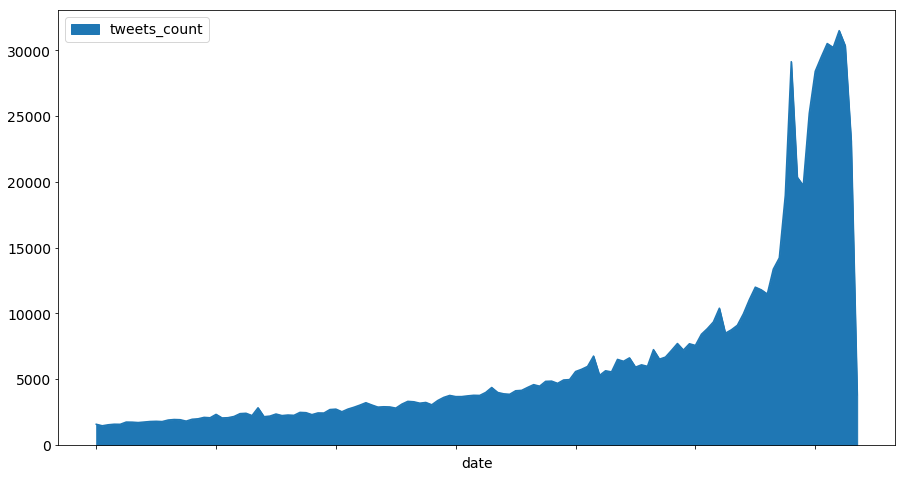

In [14]:
tweets_by_dates.loc['2018-01-01':].plot.area()

In [15]:
sentiment_df = data_df.unstack(level='sentiment', fill_value=0)

In [16]:
gccsa_sentiment_df = sentiment_df.groupby(level='gccsa_area').sum()
gccsa_sentiment_df.columns = gccsa_sentiment_df.columns.droplevel(0)
sorted_columns = list(gccsa_sentiment_df.sum().sort_values(ascending=False).index.values)
gccsa_sentiment_df = gccsa_sentiment_df[sorted_columns]

In [17]:
sa4_sentiment_df = sentiment_df.groupby(level='sa4_area').sum()
sa4_sentiment_df.columns = sa4_sentiment_df.columns.droplevel(0)
sorted_columns = list(sa4_sentiment_df.sum().sort_values(ascending=False).index.values)
sa4_sentiment_df = sa4_sentiment_df[sorted_columns]

## Load Aurin Data

### SA4 Median Income

In [18]:
data = [item['properties'] for item in aurin_db['SA4_median_income']['features']]
sa4_median_income_df = pd.DataFrame.from_records(data).set_index('sa4_name16')
del sa4_median_income_df['sa4_code16']
#sa4_median_income_df.head()

### SA4_Labour_Force

In [19]:
data = [item['properties'] for item in aurin_db['SA4_Labour_Force']['features']]
sa4_labour_force_df = pd.DataFrame.from_records(data).set_index('sa4_name16')
del sa4_labour_force_df['sa4_code16']
#sa4_labour_force_df.head()

### GCCSA Median Income

In [20]:
data = [item['properties'] for item in aurin_db['GCCSA_median_income']['features']]
gccsa_median_income_df = pd.DataFrame.from_records(data).set_index('gcc_name16')
del gccsa_median_income_df['gcc_code16']
#gccsa_median_income_df

### GCCSA_Labour_Force

In [21]:
data = [item['properties'] for item in aurin_db['GCCSA_Labour_Force']['features']]
gccsa_labour_force_df = pd.DataFrame.from_records(data).set_index('gcc_name16')
del gccsa_labour_force_df['gcc_code16']
#gccsa_labour_force_df

## GCCSA Data

In [22]:
gccsa_df = gccsa_sentiment_df.join(gccsa_median_income_df).join(gccsa_labour_force_df)
gccsa_df.to_csv('gccsa.csv')

## SA4 Data

In [23]:
sa4_df = sa4_sentiment_df.join(sa4_median_income_df).join(sa4_labour_force_df)
sa4_df.to_csv('sa4.csv')

In [24]:
sa4_df

,Neutral,Positive,Negative,nan,median_tot_fam_inc_weekly,median_tot_prsnl_inc_weekly,p_tot_emp_tot,p_tot_lf_tot,p_tot_unemp_tot,p_unem_look_ptw_tot
sa4_area,,,,,,,,,,
Adelaide - Central and Hills,1776,1674,325,13,1967,700,137691,147027,9332,4751
Adelaide - North,317,337,86,3,1407,563,180185,198775,18591,7125
Adelaide - South,7032,7286,3253,60,1622,635,164500,176840,12341,5512
Adelaide - West,377,252,61,2,1554,597,104681,113466,8786,3737
Australian Capital Territory,4223,4333,1686,26,2445,1000,205419,215586,10167,5305
Ballarat,902,823,467,5,1409,559,67396,72295,4899,2084
Barossa - Yorke - Mid North,325,349,164,3,1318,535,45980,49147,3170,1111
Bendigo,694,646,284,4,1443,593,66444,70699,4258,1897
Brisbane - East,440,364,77,3,1902,717,108128,115073,6948,2904


In [25]:
#data_df.corr()

In [26]:
#sns.pairplot(sa4_df, kind='reg')

# Sentiment By States

In [27]:
sa4_sentiment_df.head()

sentiment,Neutral,Positive,Negative,nan
sa4_area,,,,
Adelaide - Central and Hills,1776,1674,325,13
Adelaide - North,317,337,86,3
Adelaide - South,7032,7286,3253,60
Adelaide - West,377,252,61,2
Australian Capital Territory,4223,4333,1686,26


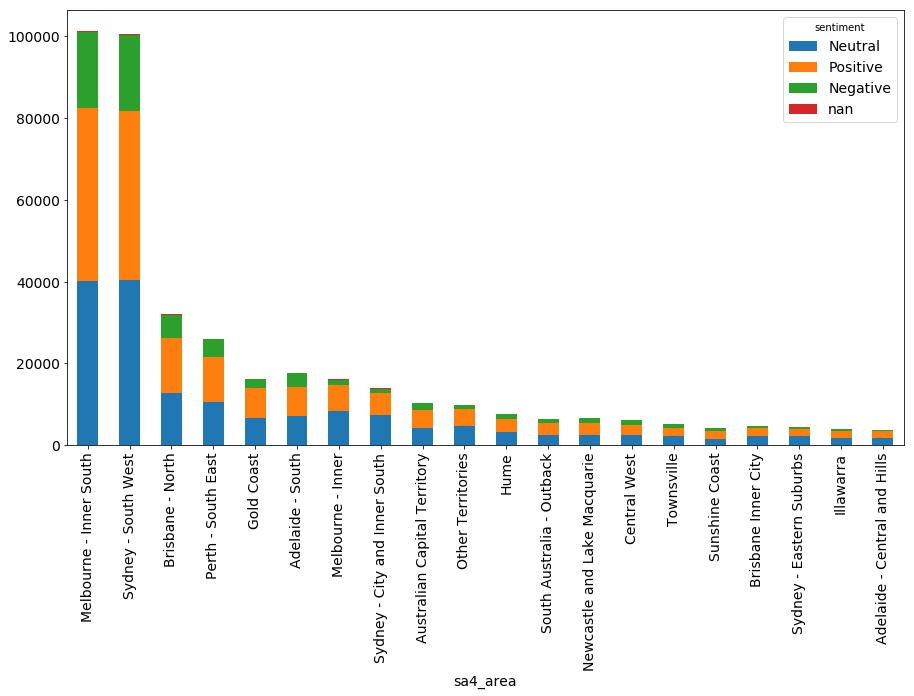

In [28]:
plot_df = sa4_sentiment_df.sort_values('Positive', ascending=False).iloc[:20]
plot_df.plot.bar(stacked=True)
plt.show()

In [29]:
totals = plot_df.sum(axis=1)
for idx in plot_df.index.values:
    plot_df.loc[idx] = plot_df.loc[idx] / totals.loc[idx] 

In [30]:
plot_df

sentiment,Neutral,Positive,Negative,nan
sa4_area,,,,
Melbourne - Inner South,0.40,0.42,0.18,2.24e-03
Sydney - South West,0.40,0.41,0.18,1.99e-03
Brisbane - North,0.40,0.42,0.18,2.40e-03
Perth - South East,0.41,0.42,0.17,1.54e-03
Gold Coast,0.41,0.46,0.14,1.11e-03
Adelaide - South,0.40,0.41,0.18,3.40e-03
Melbourne - Inner,0.51,0.40,0.09,7.46e-04
Sydney - City and Inner South,0.52,0.40,0.07,9.37e-04
Australian Capital Territory,0.41,0.42,0.16,2.53e-03


In [31]:
#* 100

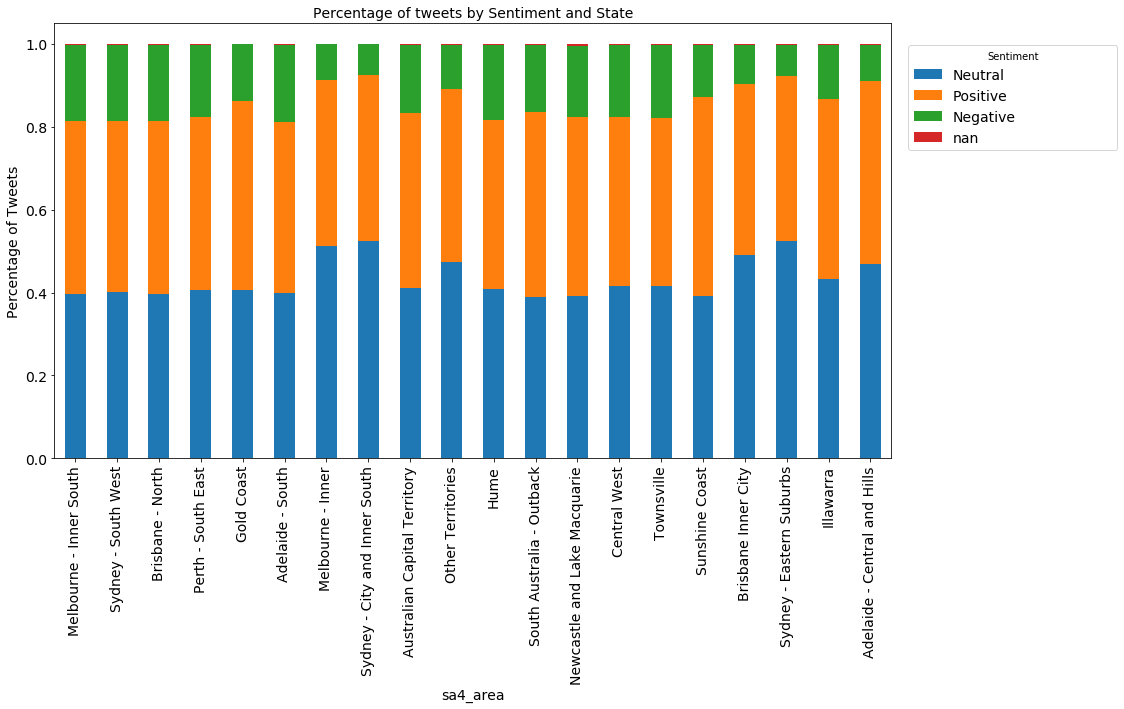

sentiment,Neutral,Positive,Negative,nan
sa4_area,,,,
Melbourne - Inner South,40%,42%,18%,0%
Sydney - South West,40%,41%,18%,0%
Brisbane - North,40%,42%,18%,0%
Perth - South East,41%,42%,17%,0%
Gold Coast,41%,46%,14%,0%
Adelaide - South,40%,41%,18%,0%
Melbourne - Inner,51%,40%,9%,0%
Sydney - City and Inner South,52%,40%,7%,0%
Australian Capital Territory,41%,42%,16%,0%


In [32]:
plot_df.plot.bar(stacked=True)
ax = plt.gca()
ax.legend(frameon=True, loc=2, bbox_to_anchor=(1.02, 0.0,.25, .95), mode='expand', borderaxespad=0.,
                      title='Sentiment')
ax.set_title('Percentage of tweets by Sentiment and State')
ax.set_ylabel('Percentage of Tweets')
plt.show()
plot_df.applymap(lambda x: '{:.0f}%'.format(x*100))

In [33]:
class TweetsDB():
    def __init__(self, cfg):
        self._cfg = cfg
        self._client = Cloudant(self._cfg['user'], self._cfg['password'], url=self._cfg['host'])
        self._client.connect()
        self._db = self._get_db()
        
    def _get_db(self):
        databases = self._client.all_dbs()
        db_name = self._cfg['tweets_db']
        if not db_name in databases:
            self._client.create_database(db_name)
        return self._client[db_name]
        
    def save_tweet(self, document):
        if not '_id' in document:
            document['_id'] = document['id_str']
        if 'id' in document:
            document.pop('id')
        self._db.create_document(document) 
        
    def update_document(self, document_id, attributes_dict):
        if attributes_dict is None:
            return False
        
        document = self._db[document_id]

        for key in attributes_dict.keys():
            document[key] = attributes_dict[key]
        document.save()
        return True

## Plotly plots

In [34]:
import plotly
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
plotly.offline.init_notebook_mode(connected=True)

In [35]:
mapbox_access_token = 'pk.eyJ1Ijoidml0YWx5LXlha3V0ZW5rbyIsImEiOiJjamd3ZGJpMTQwcDA2MzNsNjg2dTJzeG1zIn0.shxkPXdNpbwF1UI2Gm24fg'

In [36]:
sa4_points_df = pd.read_json('notebooks/sa4_center.json')
sa4_points_df.set_index('SA4_name', inplace=True)
sa4_points_df['lat'] = sa4_points_df.Centre.apply(lambda x: x[0][1])
sa4_points_df['lng'] = sa4_points_df.Centre.apply(lambda x: x[0][0])
del sa4_points_df['Centre']

In [37]:
sa4_df = sa4_df.join(sa4_points_df)

In [38]:
sa4_df.head()

,Neutral,Positive,Negative,nan,median_tot_fam_inc_weekly,median_tot_prsnl_inc_weekly,p_tot_emp_tot,p_tot_lf_tot,p_tot_unemp_tot,p_unem_look_ptw_tot,lat,lng
sa4_area,,,,,,,,,,,,
Adelaide - Central and Hills,1776,1674,325,13,1967,700,137691,147027,9332,4751,-34.97,138.84
Adelaide - North,317,337,86,3,1407,563,180185,198775,18591,7125,-34.69,138.66
Adelaide - South,7032,7286,3253,60,1622,635,164500,176840,12341,5512,-35.14,138.57
Adelaide - West,377,252,61,2,1554,597,104681,113466,8786,3737,-34.87,138.53
Australian Capital Territory,4223,4333,1686,26,2445,1000,205419,215586,10167,5305,-35.49,149.00


In [39]:
scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]
#colorscale='Viridis'

data = [ dict(
        type = 'scattergeo',
        lat=sa4_df.lat,
        lon=sa4_df.lng,
        text =sa4_df.index.values,
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = sa4_df['Positive'],
            cmax = sa4_df['Positive'].max(),
            colorbar=dict(
                title="Positive Sentiment Count"
            )
        )
        )]

layout = dict(
        #title = 'Most trafficked US airports<br>(Hover for airport names)',
        colorbar = True,
    width=1000,
    height=900,
    margin=go.Margin(l=10, r=10, b=10, t=10, pad=4
    ),
        geo = dict(
            #domain=dict(x=[0,3], y=[-1,1]),
            resolution=50,
            projection = dict( type = 'Mercator'),
            lataxis=dict(range=[-45.0, -5.0]),
            lonaxis=dict(range=[110.0, 155.0] ),
                        
            showland = True,
            showcountries=True,
            showsubunits=True,
            
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
        ),
    )

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False, filename='' )

In [40]:
sa4_df

,Neutral,Positive,Negative,nan,median_tot_fam_inc_weekly,median_tot_prsnl_inc_weekly,p_tot_emp_tot,p_tot_lf_tot,p_tot_unemp_tot,p_unem_look_ptw_tot,lat,lng
sa4_area,,,,,,,,,,,,
Adelaide - Central and Hills,1776,1674,325,13,1967,700,137691,147027,9332,4751,-34.97,138.84
Adelaide - North,317,337,86,3,1407,563,180185,198775,18591,7125,-34.69,138.66
Adelaide - South,7032,7286,3253,60,1622,635,164500,176840,12341,5512,-35.14,138.57
Adelaide - West,377,252,61,2,1554,597,104681,113466,8786,3737,-34.87,138.53
Australian Capital Territory,4223,4333,1686,26,2445,1000,205419,215586,10167,5305,-35.49,149.00
Ballarat,902,823,467,5,1409,559,67396,72295,4899,2084,-37.38,143.73
Barossa - Yorke - Mid North,325,349,164,3,1318,535,45980,49147,3170,1111,-33.66,138.45
Bendigo,694,646,284,4,1443,593,66444,70699,4258,1897,-36.60,144.09
Brisbane - East,440,364,77,3,1902,717,108128,115073,6948,2904,-27.55,153.33


In [41]:
scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]

data = [ dict(
        type = 'scattermapbox',
        lat=sa4_points_df.lat,
        lon=sa4_points_df.lng,
        text =sa4_points_df.index.values,
        mode = 'markers+text',
    

        marker=go.Marker(
            #symbol='square-15.svg',
            size = 12,
            opacity = 0.6,
            #reversescale = True,
            autocolorscale = False,
            #line = dict(width=1, color='rgba(102, 102, 102)'),
            colorscale = 'Viridis',
            cmin = 0,
            #color = sa4_df['Positive'],
            color = sa4_df['median_tot_prsnl_inc_weekly'],
            cmax = sa4_df['median_tot_prsnl_inc_weekly'].max(),
            colorbar=dict( title="Positive Sentiment")
            )
        )]

layout = dict(
        #title = 'Most trafficked US airports<br>(Hover for airport names)',
        colorbar = True,
    width=1000,
    height=850,
    margin=go.Margin(l=10, r=10, b=10, t=10, pad=4),
        mapbox=dict(
                    accesstoken=mapbox_access_token,
                    bearing=0,
                    center=dict(
                        lat=-28,
                        lon=134
                    ),
        pitch=0,
        zoom=3.8
    ),
    )

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False, filename='' )